In [1]:
# Helper functions for saving/loading Python dictionaries via pickle
# Don't worry about the details of these functions
# They'll be used to load already-completed nested sampling runs (if needed)

import pickle

def save_dict(dict_, filename_,protocol=pickle.DEFAULT_PROTOCOL):
    with open(filename_, 'wb') as f:
        pickle.dump(dict_, f,protocol=protocol)

def load_dict(filename_, protocol=None):
    with open(filename_, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

# A few Gaussian process fundamentals

## From finite to infinite dimensions

While a multivariate Gaussian distribution $\mathcal{N}$ is specified by a mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{K}$, a Gaussian *process* $\mathcal{GP}$ is specified by a mean *function* and a covariance *function*: in principle, both *infinite-dimensional* (!) objects. A draw i.e. random sample from this GP will be a random *function* rather than a finite-dimensional random vector.

## Using a GP to learn unknown functions

Suppose we have a set of observations $\mathcal{D} = \left\{ {({x_i},{y_i})} \right\}_{i = 1}^n = ({\mathbf{x}},{\mathbf{y}})$, and we wish to find the relationship between the inputs and outputs. Let's assume this relationship takes the form

$$
y_i=f(x_i)+\epsilon_i,
$$

where $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$, and we do not know the functional form of $f(x)$. If we have some prior knowledge about certain properties of $f(x)$, however, we can place a GP prior on the function $f(x)$, with our prior knowledge about $f(x)$ built into the covariance structure of the GP:

\begin{equation}
f\sim\mathcal{GP}(\mu,k);
\end{equation}

here, $\mu(x)$ encapsulates any deterministic part of the relationship between $y$ and $x$ we do know how to write down (it could be that $\mu(x)=0$ if we don't have any such knowledge); it is referred to as the *mean function* of the GP. Meanwhile $k(x_i,x_j)$ is referred to as a *covariance kernel function*, and is a recipe for computing the covariance between any two observations. Of course, it would be inconvenient to have to specify infinitely many covariances!

For any set of locations $\mathbf{x}={x_1,x_2,\ldots,x_n}$, we may define the *covariance matrix* thus:

$$
{\mathbf{K}}({\mathbf{x}},{\mathbf{x}}) = \left( {\begin{array}{*{20}{c}}
  {k({x_1},{x_1})}&{k({x_1},{x_2})}& \cdots &{k({x_1},{x_n})} \\ 
  {k({x_2},{x_1})}&{k({x_2},{x_2})}& \cdots &{k({x_2},{x_n})} \\ 
   \vdots & \vdots & \ddots & \vdots  \\ 
  {k({x_n},{x_1})}&{k({x_n},{x_2})}& \cdots &{k({x_n},{x_n})} 
\end{array}} \right),
$$

so we only actually compute covariances between a finite number of locations, e.g. where we have observed the function $f$. Note that ${\mathbf{K}}({\mathbf{x}},{\mathbf{x}})$ must be *positive semi-definite* for it to be a valid covariance matrix. This means that not all functions are valid covariance functions.

For convenience, we can absorb the uncorrelated observational noise, $\epsilon_i$, into our covariance function by transforming $k(x_i,x_j)\to k(x_i,x_j)+\sigma_i^2\delta_{ij}$. I.e., we'll simply include the observational (white) noise terms in the diagonal of our covariance matrix when we're working with GPs, rather than having to deal with it separately. Additive white Gaussian noise is, after all, just a special case of a GP.

## A few key GP identities

It turns out that placing a GP prior on $f$ leads us to a GP posterior distribution: $f|\mathcal{D}\sim\mathcal{GP}(\mu_\mathcal{D}, k_\mathcal{D})$, with

$$
{\mu _\mathcal{D}}(x) = \mu (x) + {\mathbf{K}}(x,{\mathbf{x}}){{\mathbf{K}}^{ - 1}}({\mathbf{y}} - \boldsymbol\mu ({\mathbf{x}})),
$$

and

$$
{k_\mathcal{D}}({x_i},{x_j}) = k({x_i},{x_j}) - {\mathbf{K}}({x_i},{\mathbf{x}}){{\mathbf{K}}^{ - 1}}{\mathbf{K}}({\mathbf{x}},{x_j}). 
$$

${\mu _\mathcal{D}}(x)$ provides us with a best posterior estimate for the function $f$, given the prior $\mathcal{GP}(\mu,k)$ and the observed data $\mathcal{D}$, while ${k_\mathcal{D}}({x_i},{x_j})$ defines our uncertainty in the posterior estimate. The remarkable properties of multivariate Gaussian distributions enable us to convert prior distribution over an infinite dimensional function space into marginal and conditional distributions over a finite-dimensional space. 

Note that the posterior variance ${k_\mathcal{D}}({x_i},{x_j})$  is equal to the prior variance, $k({x_i},{x_j})$, minus a positive term. The observed data provides us with additional constraints on the model $f$, so the posterior variance is always smaller than the prior variance. 

We are thus equipped with all the apparatus needed to learn an unknown function from some observed data, to make predictions outside of our observations, and even to place error bars on the function we have learned.

Assuming our covariance kernel function is controlled by some set of hyperparameters $\boldsymbol{\theta}$, and our mean function by parameters $\boldsymbol{\phi}$, the log marginal likelihood for our observations $\mathbf{y}$, $\log \mathcal{L} = \log p({\mathbf{y}}|{\mathbf{x}},\boldsymbol \theta ,\boldsymbol \phi )$, obtained by marginalising analytically over unobserved function values, is given by:

$$
\log \mathcal{L} =  - \tfrac{1}{2}\log \det {\mathbf{K}}(\boldsymbol \theta ) - \tfrac{1}{2}{{\mathbf{r}}^{\text{T}}}{\mathbf{K}}^{ - 1}{(\boldsymbol \theta )}{\mathbf{r}} - \tfrac{N}{2}\log 2\pi, \label{eq:GP-likelihood}
$$

where $\mathbf{r}:={\mathbf{y}} - {\mathbf{m}}(\boldsymbol \phi )$ is a vector of residuals. The first term, $- \tfrac{1}{2}\log \det {\mathbf{K}}(\boldsymbol \theta )$, is a complexity penalty term, which measures and penalises the complexity of the model; the second term plays the role of a goodness-of-fit measure, and is the only term which depends on the observations $\mathbf{y}$; and the third term is a normalisation term.

## Some common covariance kernel functions

### White noise

White noise with variance $\sigma_i$ on the $i$th datapoint is represented by

$$
{k_{{\text{WN}}}}({x_i},{x_j}) = {\sigma ^2}\delta_{ij},
$$

where $\delta_{ij}$ is the Kronecker delta function ($\delta_{ij}=1$ if $i=j$, otherwise $\delta_{ij}=0$). This kernel is usually used to account for uncertainty in observed data, and is typically found added to other kernels. The use of a $k_\text{WN}$ kernel in isolation, along with a zero-mean function, reduces a GP model to the special case of a simple additive white Gaussian noise (AWGN) model; all functions generated by such a GP will simply be white Gaussian noise.

### Squared exponential kernel

The SE covariance kernel is given by

$$
{k_{{\text{SE}}}}({x_i},{x_j}) = {h^2}\exp \left( {\frac{{ - {{({x_i} - {x_j})}^2}}}{2\lambda^2 }} \right);
$$

the kernel is governed by two so-called *hyperparameters* $h$ and $\lambda$, which govern the output and input (length or time) scale of functions. These parameters, and the parameters of GP covariance kernels more generally, are referred to as *hyperparameters* as they govern the properties of a prior distribution, rather than acting explicitly on the functional form of curves drawn from the distribution. Functions drawn from an SE kernel  will be infinitely differentiable, and will exhibit smooth variations with a typical time (or length) scale of $\lambda$.

### Matérn class of kernels

The Matérn class of covariance functions is defined by $h$ (an output scale), $\lambda$ (an input scale), and another hyperparameter $\nu$ that controls the degree of differentiability of the resultant functions modelled by a GP with a Mat\'ern covariance kerel, such that they are only $\nu+\tfrac{1}{2}$ times differentiable. As $\nu\to\infty$,  the functions become infinitely differentiable, and the Mat\'ern kernel becomes the SE kernel. At the other end of the spectrum, setting $\nu=\tfrac{1}{2}$ gives us the Ornstein–Uhlenbeck (OU) or exponential kernel:

$$
{k_{{\text{OU}}}}({x_i},{x_j}) = {h^2}\exp \left( {\frac{{ - |{x_i} - {x_j}|}}{\lambda }} \right); \label{eq:OU-kernel}
$$
this kernel looks very similar (superficially) to the SE kernel, but the functions it models are *not* smooth. Instead, they are only once differentiable, and correspond to the random motion of a massive Brownian particle under the influence of friction.

### Quasi-periodic (locally periodic) kernel

A commonly-used quasi-periodic kernel, obtained by multiplying a periodic kernel with a SE kernel (with the latter kernel serving to specify the rate of evolution of the periodic signal), is:

$$
{k_{{\text{QP-SE}}}}({x_i},{x_j}) = {h^2}\exp \left( { - \frac{{{{\sin }^2}\left( {\tfrac{{\pi ({x_i} - {x_j})}}{P}} \right)}}{{2\lambda _\text{p}^2}} - \frac{{{{\left( {{x_i} - {x_j}} \right)}^2}}}{{2\lambda _\text{e}^2}}} \right).
$$

The hyperparameter $\lambda$ is now a "roughness" parameter, defined relative to $P$, and sets the harmonic complexity of functions: large values of $\lambda$ will lead to simple, sinusoidal variations, while smaller values will lead to more complicated periodic functions, with more structure within a single period. Meanwhile $\lambda_\text{e}$ defines how rapidly functions evolve, i.e. decay away from strict periodicity, while $\lambda_\text{p}$ controls the harmonic complexity of functions.

### Many other possibilities

A broad range of function properties may be conveniently encoded into a covariance kernel, and thus into a GP prior over functions. These properties include typical length or time-scales for variations, stationarity (translation invariance), isotropy or anisotropy (direction independence or dependence), signal variance, noise variance, periodicity or quasi-periodicity, degree of smoothness, abrupt changes in input or output scales, relationships between observations and derivative or integral observations, and more. 

It turns out that the sum or product of valid covariance kernels will always yield another valid covariance kernel. Another useful result is that a valid covariance function under any arbitrary (smooth) map remains a valid covariance function. For any function $u: x\to u(x)$, a covariance function $k()$ defined over a range of $x$ gives rise to a valid covariance function $k'()$ over the domain of $u$. For more details, check out the [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).

# Gaussian processes: DIY practical

## Let's implement basic GP regression in Python

### Log likelihood

$$
\log \mathcal{L}(\boldsymbol{\theta}|\mathcal{D}) =  - \tfrac{1}{2}\log \det {\mathbf{K}}(\boldsymbol \theta ) - \tfrac{1}{2}{{\mathbf{r}}^{\text{T}}}{\mathbf{K}}^{ - 1}{(\boldsymbol \theta )}{\mathbf{r}} - \tfrac{N}{2}\log 2\pi
$$

In [2]:
import numpy as np

def logL_GP(residuals, K):
    '''  
    Gaussian process log likelihood (residuals := y - mean)
    '''  
    
    logL = -0.5*(np.linalg.slogdet(K)[1] 
            + residuals.T@np.linalg.inv(K)@residuals
            + len(residuals)*np.log(2*np.pi))
              
    return logL

### Predictive mean, covariance

Given: 
* Model residuals $\mathbf{y}\in\mathbb{R}^N$, a.k.a. training points, at locations $\mathbf{x}$, and
* arbitrary locations $\mathbf{x_*}\in\mathbb{R}^M$, a.k.a. test or sample points, where we want to evaluate the predictive mean and covariance,

we can compute the latter via: 

$$
{\boldsymbol{\mu} _\mathcal{D}} = {\boldsymbol{\mu} _\mathcal{D}}(\mathbf{x_*}) + {\mathbf{K}}(\mathbf{x_*},{\mathbf{x}})\cdot {{\mathbf{K}}^{ - 1}}(\mathbf{x},\mathbf{x})\cdot{\mathbf r}
$$

$$
{\boldsymbol{K_\mathcal{D}}} = {\mathbf{K}}(\mathbf{x_*},{\mathbf{x_*}}) -  {\mathbf{K}}(\mathbf{x_*},{\mathbf{x}})\cdot {{\mathbf{K}}^{ - 1}}({\mathbf{x}},{\mathbf{x}})\cdot{\mathbf{K}}({\mathbf{x_*}},\mathbf{x})^{\rm T}. 
$$

The subscript $\mathcal{D}$ above indicates that we are considering the mean and covariance conditioned on our data $\mathcal{D}$.

Hint: in general, it is better (faster, more accurate) to solve numerically an equation of the form $\mathbf{A} \boldsymbol{x}=\boldsymbol{b}$, for a matrix $\mathbf{A}$ and vectors $\boldsymbol{x}$ and $\boldsymbol{b}$, rather than trying to compute $\mathbf{A}^{-1}\boldsymbol{b}$ directly. Refer to ``scipy.linalg.solve`` [[link]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html). 

In [3]:
def pred_GP(X, residuals, Xs, sig_obs, cov_func, cov_theta):
    '''
    GP predictive posterior distribution.
    Relevant reference: Roberts et al. 2012, eqn. 3.8-3.9
    '''

    # Shorthand notation used below:
    # K = K(X,X); Kx = K(Xs,X); Kss = K(Xs,Xs)

    # Compute [N x N] covariance matrix for N training points
    # Include white noise variance associated with observations
    K = cov_func(X,X,cov_theta, add_sig_obs=True)

    # Evaluate [M x M] covariance matrix for M test points
    Kss = cov_func(Xs,Xs,cov_theta, add_sig_obs=False)

    # Evaluate [M x N] covariances for cross-terms
    Ks = cov_func(Xs,X,cov_theta, add_sig_obs=False)

    # Compute product inv(K) x residuals
    invK_res = spl.solve(K, residuals, sym_pos=True)


    # Predictive mean (assuming zero mean function) and covariance
    pred_mean = Ks.dot(invK_res)

    # Compute product inv(K) x Ks.T ~ [N x N][N x M]
    invK_KsT =  spl.solve(K, Ks.T, sym_pos=True)

    # Compute [M x M] covariance matrix for M test points
    pred_cov = Kss - Ks.dot(invK_KsT)
    pred_err = np.sqrt(pred_cov.diagonal())

    return pred_mean, pred_err

### White noise kernel

$$
{k_{{\text{WN}}}}({x_i},{x_j}) = {\sigma ^2}\delta_{ij},
$$

In [4]:
def compute_K_WN(X1, X2, sig_obs, add_sig_obs=True):
    ''' White noise kernel '''
    
    K_WN = np.zeros((len(X1),len(X2)))
    
    # Add white noise to covariance matrix
    if add_sig_obs:
        np.fill_diagonal(K_WN, K_WN.diagonal() + sig_obs**2)

    return K_WN

### QP kernel

$$
{k_{{\text{QP-SE}}}}({x_i},{x_j}) = {h^2}\exp \left( { - \frac{{{{\sin }^2}\left( {\tfrac{{\pi ({x_i} - {x_j})}}{P}} \right)}}{{2\lambda _\text{p}^2}} - \frac{{{{\left( {{x_i} - {x_j}} \right)}^2}}}{{2\lambda _\text{e}^2}}} \right).
$$

In [5]:
def compute_K_QP(X1, X2, theta, **kwargs):
    '''
    Quasi-periodic GP covariance kernel
    '''

    # Calculate Euclidean distance via ufunc outer product.
    tau = np.subtract.outer(X1,X2)

    # Extract hyper-parameters
    h, P, lambda_p, lambda_e = theta[0:4]
    
    # Calculate covariance matrix
    K_QP = (h**2)*np.exp(-((np.sin(np.pi*tau/P)**2)/(lambda_p**2)
         + (tau/lambda_e)**2)/2 )
    
    return K_QP

### Test to see if we get correct output

[0.81618222 0.39378423 0.04800983 0.54712864 0.03645246 0.18681904
 0.27813066 0.42822079 0.53016823 0.63583551 0.79201045 0.05377314
 0.19604567 0.0909382  0.65177241 0.01779536 1.01858565 0.2551873
 0.7403492  0.32919867 0.14955152 0.7246989  0.03884445 0.2625105
 0.1456483  0.2403723  0.9430531  0.03284979 0.43287342 0.41930064
 0.18679949 1.15190595 0.14920922 0.36997718 0.06147957 0.08787311
 0.88514229 0.01076473 0.77901985 0.87138065 1.07725164 1.15047433
 0.87015883 0.02749548 0.25380694 0.22542885 0.36905789 1.16181874
 0.844543   0.08267997 0.6368808  0.61247961 1.20801674 0.33945907
 0.68988419 0.80135145 0.13060395 0.06815951 0.63760728 0.99901859
 1.03054093 0.17011419 1.11118195 0.67941131 0.01461932 0.68152541
 0.4646593  1.11211514 0.70952311 0.08850827 1.10041465 0.91846026
 0.30145174 0.85313002 1.20399878 0.4410695  0.4747232  0.27460431
 0.99099609 0.29634159 0.45865056 0.5778942  0.1619604  0.0151186
 0.87922385 0.17600787 0.2261211  0.0793682  0.86741621 0.0811533

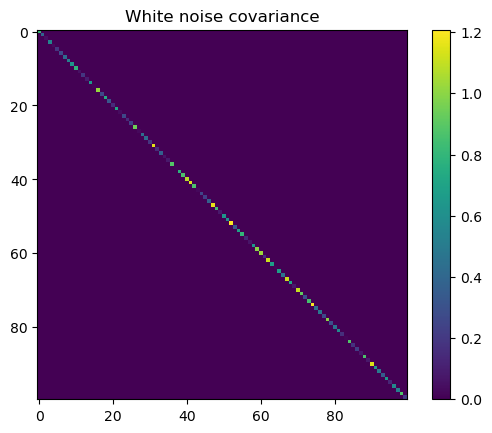

In [8]:
# observation times
X1 = X2 = np.linspace(-10,10,100)

# observation errors
np.random.seed(999)
sig_obs = 0.1+np.random.rand(100)

# white noise covariance matrix
K_WN = compute_K_WN(X1, X2, sig_obs)

# plot/print covariance matrix

import matplotlib.pyplot as plt

plt.imshow(K_WN)
plt.title('White noise covariance')
print(K_WN.diagonal())
plt.colorbar()

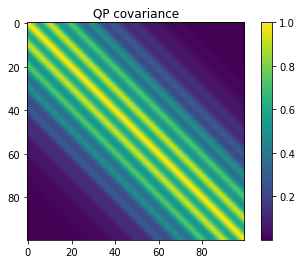

In [7]:
# QP hyper-parameters (h, P, lambda_p, lambda_e)
theta = [1, 2, 1, 5]

# observation errors
np.random.seed(999)
sig_obs = 0.1+np.random.rand(100)

# white noise covariance matrix
K_QP = compute_K_QP(X1, X2, theta)

# plot/print covariance matrix
plt.imshow(K_QP)
plt.title('QP covariance')
plt.colorbar()

# compute log likelihood for dummy residuals

In [8]:
K = K_QP + K_WN
residuals = 0.1*np.random.randn(100)

print(logL_GP(residuals, K))

-59.32446206261202


### FYI - here is a slightly faster version of log likelihood function

In [9]:
import scipy.linalg as spl

def logL_GP_faster(res, K, K_is_diag=False):
    # Gaussian process log likelihood (res := y - mean)
    
    # Calculations can be done much quicker when K diagonal
    if K_is_diag:
        K_diag = np.diagonal(K)
        gof = np.sum(res*res/K_diag)
        logdet = np.sum(np.log(K_diag))
    else:
        # Use Cholesky decomposition of PSD matrix to solve matrix equation
        # of form Ax=b, and calc logdet, in a numerically efficient way
        factor, flag = spl.cho_factor(K)
        gof = np.dot(res,spl.cho_solve((factor,flag),res))
        
        # Below logdet calculation slightly faster than np.linalg.slogdet
        logdet = 2*np.sum(np.log(np.diag(factor)))
    
    return -0.5*(gof + logdet + len(res)*np.log(2*np.pi))

In [10]:
print(logL_GP_faster(residuals, K))

%timeit logL_GP(residuals,K)
%timeit logL_GP_faster(residuals,K)

-59.324462062612014
502 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
66 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Let's draw some samples from our QP, WN kernels

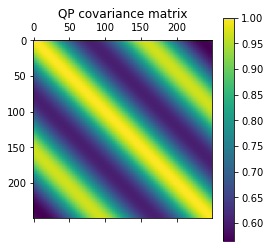

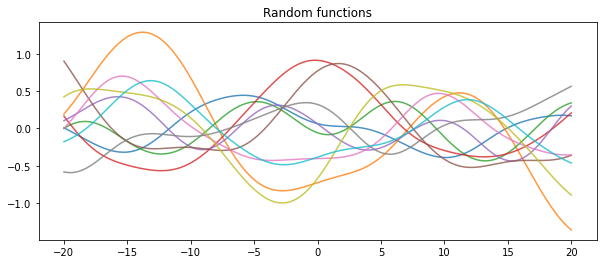

In [11]:
t = np.linspace(-20,20,250)

h, P, lambda_p, lambda_e = 1, 25, 1, 100
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])

import matplotlib.pyplot as plt

# Plot covariance matrix K

plt.matshow(K)
plt.title('QP covariance matrix')
plt.colorbar()

# Draw and plot samples using K

GP_sample = np.random.multivariate_normal

def draw_and_plot_samples(t,K):
    plt.figure(figsize=(10,4))
    plt.title('Random functions')
    for i in range(10):
        sample = GP_sample(np.zeros(len(t)), K)
        plt.plot(t, sample-np.mean(sample), alpha=0.8)
        
draw_and_plot_samples(t,K)

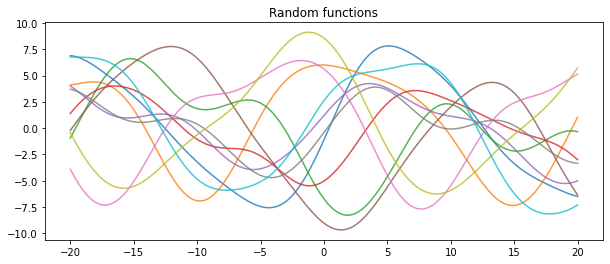

In [12]:
# Let's try different hyper-parameter values
# Bigger amplitude

h, P, lambda_p, lambda_e = 10, 25, 1, 100
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])
draw_and_plot_samples(t,K)

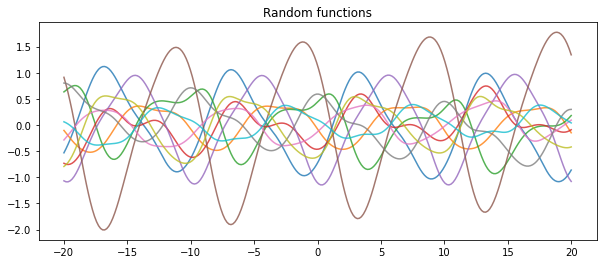

In [13]:
# Shorter period

h, P, lambda_p, lambda_e = 1, 10, 1, 100
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])
draw_and_plot_samples(t,K)

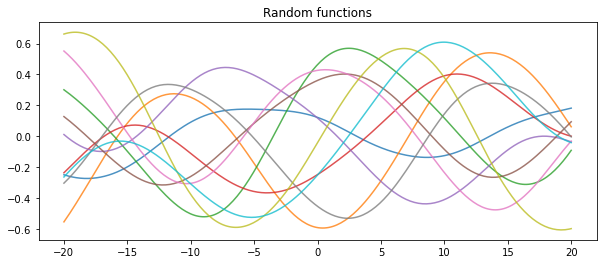

In [14]:
# Less structure per period

h, P, lambda_p, lambda_e = 1, 25, 2, 100
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])
draw_and_plot_samples(t,K)

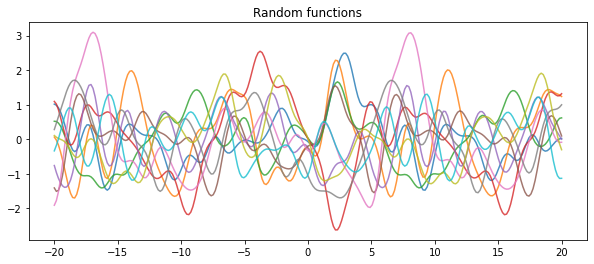

In [15]:
# More structure per period; slow evolution

h, P, lambda_p, lambda_e = 1, 25, 0.125, 1000
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])
draw_and_plot_samples(t,K)

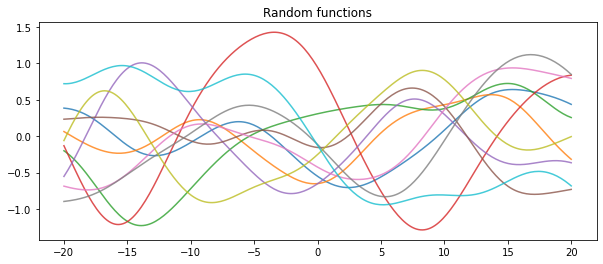

In [16]:
# Less structure per period; rapid evolution

h, P, lambda_p, lambda_e = 1, 25, 1, 25
K = compute_K_QP(t, t, [h, P, lambda_p, lambda_e])
draw_and_plot_samples(t,K)

## Let's generate some quasi-periodic data to fit

Consider the unusual function $f(t)$, defined as follows:

$$
f(t) := 2\sin \left( {\tfrac{{2\pi t}}{{27}}} \right)\cos \left( {\tfrac{{2\pi t}}{{27}}} \right) + {e^{ - |t|/100}} \cdot \frac{2}{5}\sum\limits_{j =  - 5}^5 {\sin (\tfrac{{2\pi t}}{{27 + j/2}})}  + \frac{t}{{50}}
$$

If $t$ is time in days, then $f(t)$ describes the sum of a sinusoidal signal (with period $13.5$ d), a linear term, and $11$ different sinusoids with periods uniformly spaced between $24.5$ and $29.5$ d, each of which has an exponentially-decaying amplitude. For $|t|\lesssim100$, $f(t)$ will exhibit smooth, quasi-periodic variations; a GLS periodogram of $f(t)$ sampled densely on this domain will show a sharp peak at $13.5$ d, and a broad complex of peaks around $27\pm5$ d.

Let's generate data using this function $f(t)$, and then try to fit the data, pretending we don't know the functional form of $f$.

Text(0, 0.5, 'y(t)')

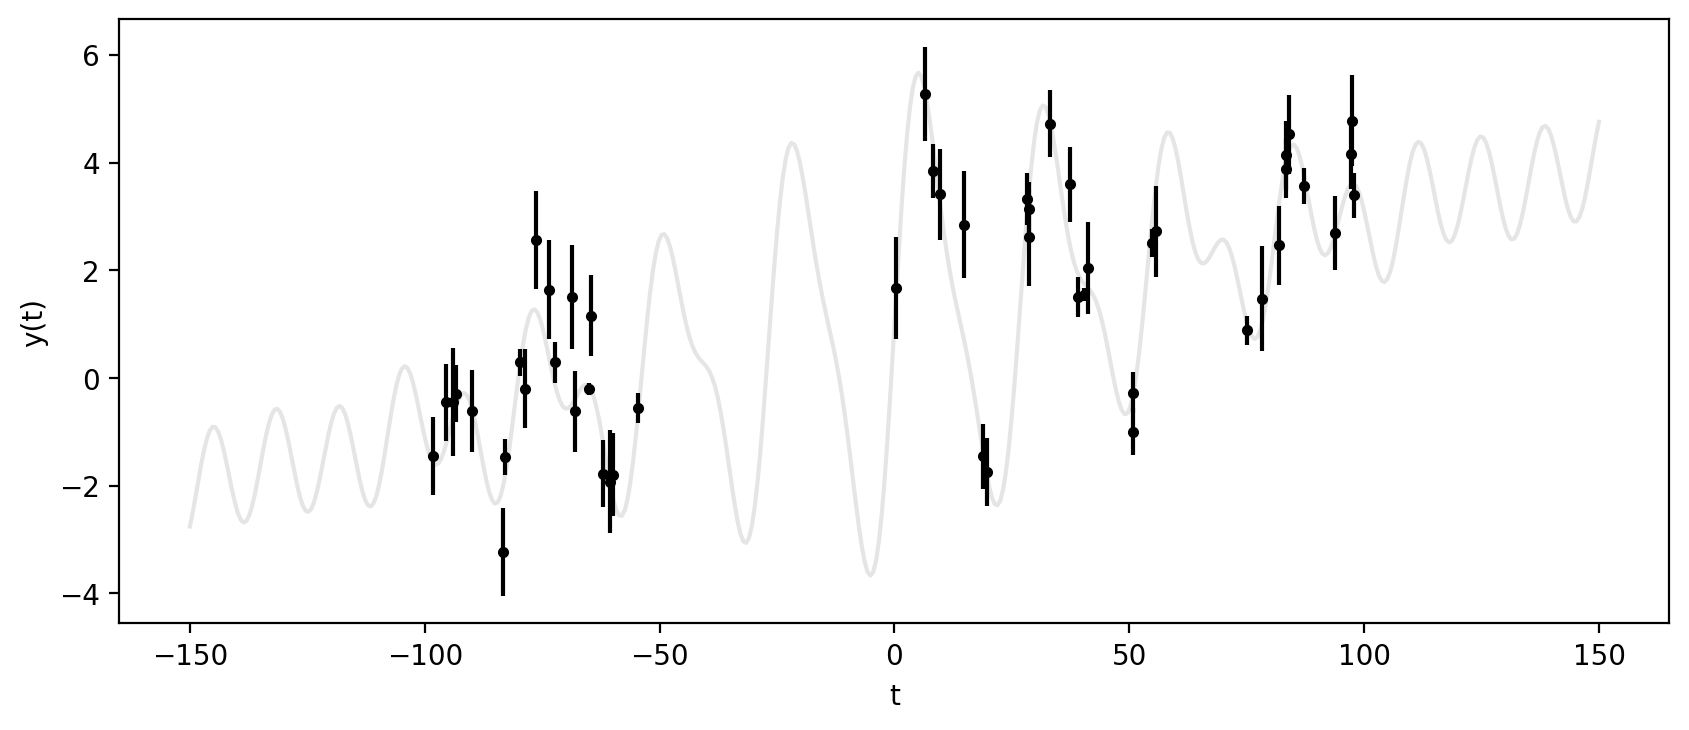

In [17]:
np.random.seed(999)

t_obs = np.sort(np.append(
    np.random.uniform(-100, -50, 20),
    np.random.uniform(0, 100, 30),)) 

yerr = np.random.uniform(0.1, 1.0, len(t_obs))

def quasi_periodic_fxn(t):
    
    y = 1 + t/50 + np.sin(2*np.pi*t/13.5)
    
    for j in range(-5,6):
        y += 0.4*(np.exp(-np.abs(t)/100)*
                  np.sin(2*np.pi*t/(27+j/2)))
    
    return y

y_obs = quasi_periodic_fxn(t_obs) + yerr*np.random.randn(len(t_obs))

t_true = np.linspace(-150, 150, 500)
y_true = quasi_periodic_fxn(t_true)

plt.figure(figsize=(10,4),dpi=200)
plt.plot(t_true, y_true, "k", lw=1.5, alpha=0.1)
plt.errorbar(t_obs, y_obs, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("t")
plt.ylabel("y(t)")


We will place a GP prior on $f$: $f\sim\mathcal{GP}(\mu,k)$. Hints of periodic variation in our observations suggest using a QP kernel; we could add to our QP kernel a white-noise kernel to account for variance due to uncorrelated noise. The observations also suggest some sort of simple, long-term trend; let's therefore try a linear polynomial as our mean function.

## Use dynesty to perform nested sampling of model parameters

Nested sampling is a method for estimating the Bayesian evidence, $\mathcal{Z}$, the integral of the posterior pdf of a set of parameters, integrated over all possible parameter values. It was first proposed and developed by John Skilling. The basic idea is to approximate the evidence by integrating the prior in nested "shells" of constant likelihood. Unlike MCMC methods which can only generate samples proportional to the posterior, nested sampling simultaneously estimates both the evidence and the posterior. 

Nested sampling also has a variety of appealing statistical properties, which include well-defined stopping criteria for ending sampling; flexibility to sample from complex, multi-modal distributions; the ability to derive how statistical and sampling uncertainties impact results from a single run; and being trivially parallelizable.

Dynamic nested sampling goes further by allowing samples to be allocated adaptivelyto better sample areas of parameter space to maximize a chosen objective function. This allows a particular nested sampling algorithm to adapt to the shape of the posterior in real time, improving both accuracy and efficiency.

We will use `dynesty`, a pure-Python, MIT-licensed dynamic nested sampling package for estimating Bayesian posteriors and evidences; [[link]](https://github.com/joshspeagle/dynesty/tree/master/paper/dynesty.pdf) to release paper.

`dynesty` is designed to perform "reasonably well" across a large array of problems but is not optimized for any single one. For large-dimensional (>30 dimensions or so) problems, something like `multinest` or `polychord` may be preferable.

Because of some technical details on how nested sampling algorithm operate, most packages (including `dynesty`) are designed to sample within the $D$-dimensional unit cube. Samples are transformed to the original parameter space "on the fly" only when needed to evaluate the likelihood. Accomplishing this requires an appropriate prior transform.

In [18]:
# First define some standard prior transforms
# These are useful in general, not this problem
#  Further reading: inverse CDF (quantile) functions

from scipy.special import erfcinv

def uniform(theta, a, b):
    """ Transform X~U[0,1] to X~U[a,b]  """
    
    theta_scaled = a + (b-a)*theta
    
    return theta_scaled

def jeffreys(theta, a, b):
    """ Transform X~U[0,1] to X~log-U[a,b] """
    
    theta_scaled = np.exp(
        np.log(a) + theta*(np.log(b) - np.log(a)))
    
    return theta_scaled

def gaussian(theta, mu, sigma):
    """ Transform X~U[0,1] to X~Normal(mu, sigma) """
    
    theta_scaled = mu+sigma*(2.0**0.5)*erfcinv(2.0*(1.0-theta))
    
    return theta_scaled

In [19]:
# Define mean function
def mean_func(t, m, c):
    y = m*t + c
    return y

# Define prior transform for all parameters
def prior_transform(theta):
    
    theta_scaled = np.array(theta)  # copy theta

    # Linear slope and intercept
    theta_scaled[0] = gaussian(theta[0], 0, 1)
    theta_scaled[1] = gaussian(theta[1], 1, 1)
    
    # Amplitude h
    theta_scaled[2] = jeffreys(theta[2], 0.1, 100)

    # Period P
    theta_scaled[3] = uniform(theta[3], 1.0, 100)

    # Harmonic complexity lambda_p
    theta_scaled[4] = jeffreys(theta[4], 0.1, 10)
    
    # Decay length scale lambda_e
    theta_scaled[5] = uniform(theta[5], 10, 200)

    return theta_scaled


In [20]:
# Combine white noise & quasi-periodic covariance kernels
def K_QP_WN(X1, X2, theta, add_sig_obs=True, **kwargs):
    return (compute_K_QP(X1, X2, theta[2::]) 
            + compute_K_WN(
                X1, X2, sig_obs=yerr, add_sig_obs=add_sig_obs))

# Function to compute log likelihood, given theta (hyper-params)
def loglike(theta):
    y_res = y_obs - mean_func(t_obs, theta[0], theta[1])
    K_trial = K_QP_WN(t_obs, t_obs, theta)
    return logL_GP_faster(y_res, K_trial)

In [21]:
from dynesty import NestedSampler
import numpy as np
np.random.seed(1)

# Define the dimensionality of our problem.
ndim = 6

# Initialize our nested sampler
sampler = NestedSampler(loglike, prior_transform, ndim)

In [22]:
# Uncomment below two lines to run the nested sampler
#sampler.run_nested()
#results = sampler.results

# Or Load results
X = load_dict('DIY_GP_001.pickle')
locals().update(X)

In [23]:
# # Save data to disk
# X = {'sampler': sampler, 'results': results}
# save_dict(X,'DIY_GP_001.pickle')
# # Load results
# X = load_dict('DIY_GP_001.pickle')
# locals().update(X)

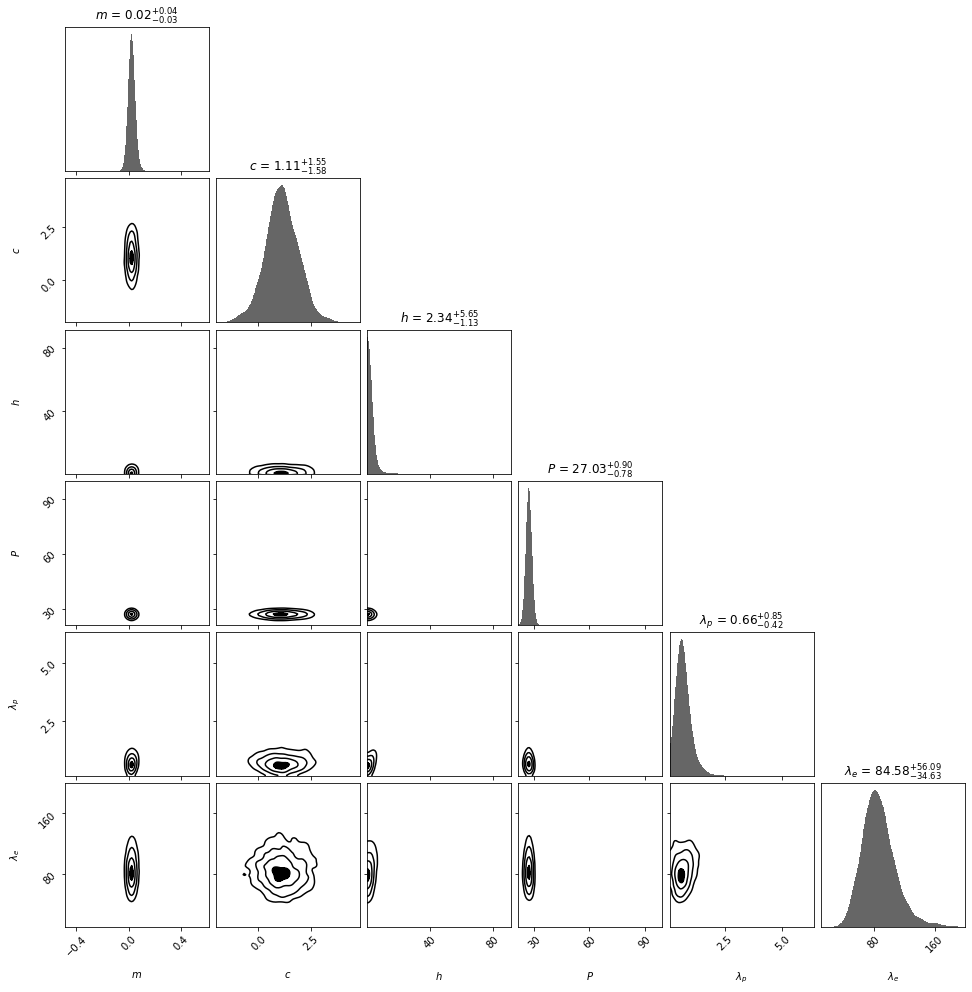

In [24]:
from dynesty import plotting as dyplot

fg, ax = dyplot.cornerplot(results, show_titles=True,
                           quantiles=None, max_n_ticks=3,
                          labels=['$m$','$c$','$h$','$P$',
                                  '$\lambda_p$','$\lambda_e$'])

## Plot GP predictive mean and variance

In [25]:
from dynesty import utils as dyfunc

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

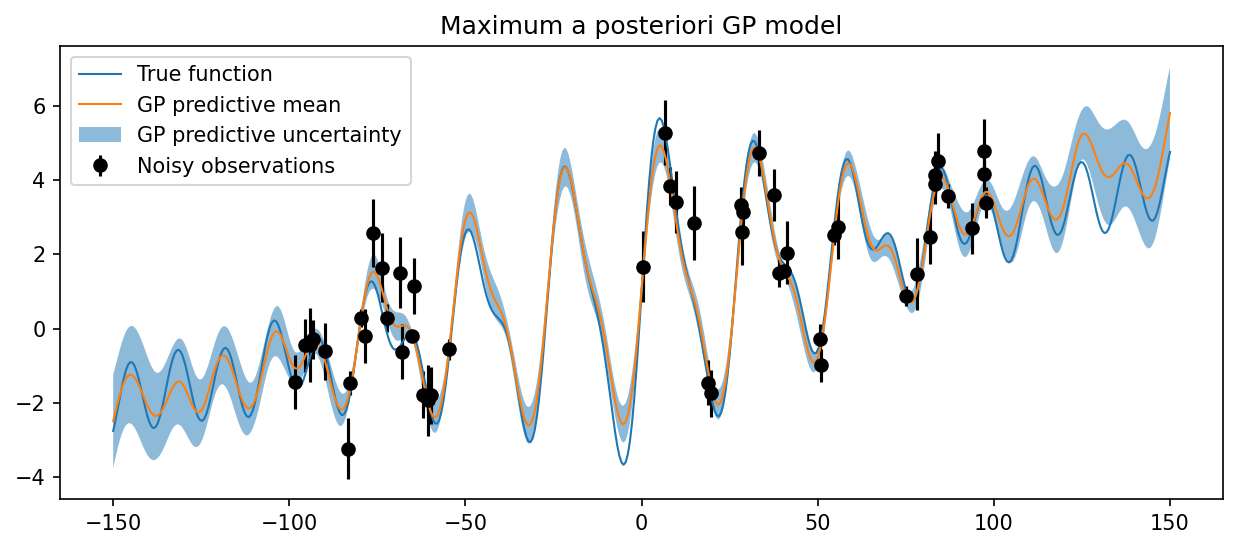

In [26]:
theta = mean
y_res = y_obs - mean_func(t_obs, theta[0], theta[1])
pred_mean, pred_err = pred_GP(t_obs, y_res, t_true, yerr, K_QP_WN, theta)
pred_mean += mean_func(t_true,  theta[0], theta[1])

plt.figure(figsize=(10,4),dpi=150)

plt.plot(t_true,y_true,lw=1, label='True function')
plt.plot(t_true,pred_mean,lw=1, label='GP predictive mean')

plt.fill_between(t_true, pred_mean-pred_err, pred_mean+pred_err, 
                 alpha=0.5,label='GP predictive uncertainty')
plt.errorbar(t_obs, y_obs, yerr=yerr, fmt='ko', label='Noisy observations')
plt.title('Maximum a posteriori GP model')

plt.legend()

# Quick demo: fitting the same data with celerte

We can see that there's some roughly periodic signal in the data as well as a longer term trend. To capture the sort-of-periodic signal, we will use a stochastically driven simple harmonic oscillator term in a celerite kernel, which has the following power spectrum:

$$S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_0\,{\omega_0}^4}{(\omega^2 - {\omega_0}^2)^2 + 2\,{\omega_0}^2\,\omega^2}$$

This kernel has 3 free hyper-parameters ($S_0$, $\omega_0$, and $Q$) and they must all be positive. We'll use a linear mean function, as before.

In [27]:
import celerite
from celerite import terms
from celerite.modeling import Model

# Periodic component: SHO kernel
# Start with more or less arbitrary hyper-parameter values

Q = 1.0
w0 = 3.0
S0 = np.var(y_obs) / (w0 * Q)

bounds = dict(log_S0=(-6, 6), log_Q=(-6, 6), log_omega0=(-6, 6.))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# Define the mean model

class MeanModel(Model):
    parameter_names = ("m", "c")

    def get_value(self, t):
        return self.m * t + self.c
    
    def compute_gradient(self, t):
        return np.array([self.m, 0])

mean_model = MeanModel(m=0, c=0)

gp = celerite.GP(kernel,mean=mean_model, fit_mean=True)
gp.compute(t_obs, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y_obs)))

Initial log likelihood: -111.35515524323048


In [28]:
print('celerite')
%timeit gp.log_likelihood(y_obs)
print('our code')
%timeit loglike(theta)

celerite
9.85 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
our code
99.5 µs ± 961 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
# Max likelihood fitting
# NB in genreal I don't recommend this approach!
# Rather use the nested sampling (Bayesian) approach, below

from scipy.optimize import minimize

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y_obs, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
mu, var = gp.predict(y_obs, t_true, return_var=True)
std = np.sqrt(var)

Final log-likelihood: -75.5292629515449


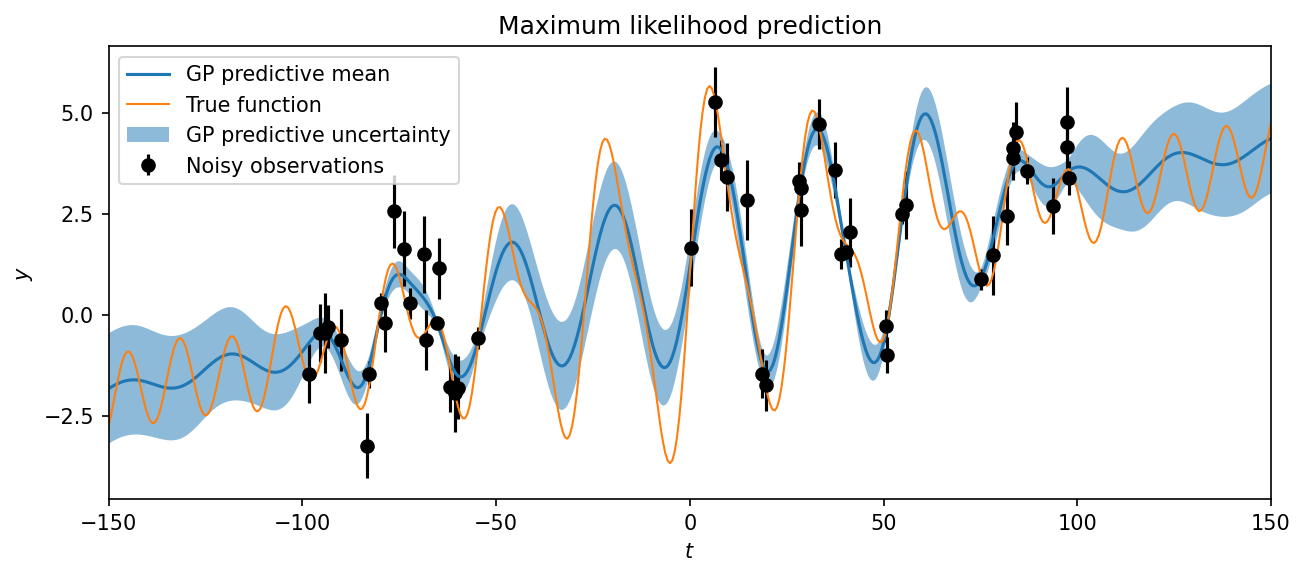

In [30]:
# Plot the data

plt.figure(figsize=(10,4),dpi=150)
plt.errorbar(t_obs, y_obs, yerr=yerr, fmt="ko", capsize=0,
            label='Noisy observations')
plt.plot(t_true, mu, label='GP predictive mean')
plt.plot(t_true,y_true,lw=1, label='True function')
plt.fill_between(t_true, mu+std, mu-std, alpha=0.5,
                 label='GP predictive uncertainty',
                 edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-150, 150)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("Maximum likelihood prediction");
plt.legend()

In [31]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y_obs) + lp

In [32]:
def prior_transform(theta):
    
    theta_scaled = np.array(theta)  # copy theta

    # Linear slope and intercept
    theta_scaled[0] = gaussian(theta[0], 0, 1)
    theta_scaled[1] = gaussian(theta[1], 1, 1)
    
    # celerite
    theta_scaled[2] = uniform(theta[2], -6, 6)
    theta_scaled[3] = uniform(theta[3], -6, 6)
    theta_scaled[4] = uniform(theta[4], -6, 6)
    
    return theta_scaled

In [33]:
from dynesty import NestedSampler
np.random.seed(1)

# Define the dimensionality of our problem.
ndim = 5

# Initialize our nested sampler
sampler = NestedSampler(log_probability, prior_transform, ndim)

In [34]:
# Uncomment below two lines to run the nested sampler
# sampler.run_nested()
# results = sampler.results

# Or Load results
X = load_dict('DIY_GP_002.pickle')
locals().update(X)

In [35]:
# # Save data to disk
# X = {'sampler': sampler, 'results': results}
# save_dict(X,'DIY_GP_002.pickle')
# # Load results
# X = load_dict('DIY_GP_002.pickle')
# locals().update(X)

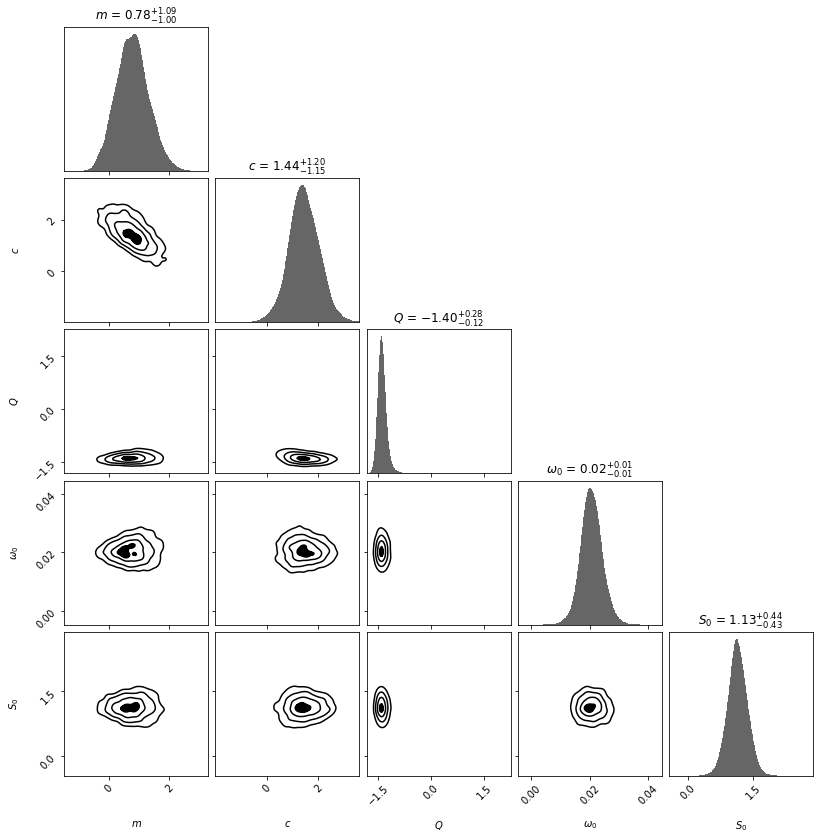

In [36]:
fg, ax = dyplot.cornerplot(results, show_titles=True,
                           quantiles=None, max_n_ticks=3,
                          labels=['$m$','$c$','$Q$','$\omega_0$',
                                  '$S_0$'])

In [37]:
# Extract posterior mean param values
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
gp.set_parameter_vector(mean)

In [38]:
# Get GP predictive mean & variance
pred_mean, pred_var = gp.predict(y_obs, t_true, return_var=True)
pred_std = np.sqrt(pred_var)

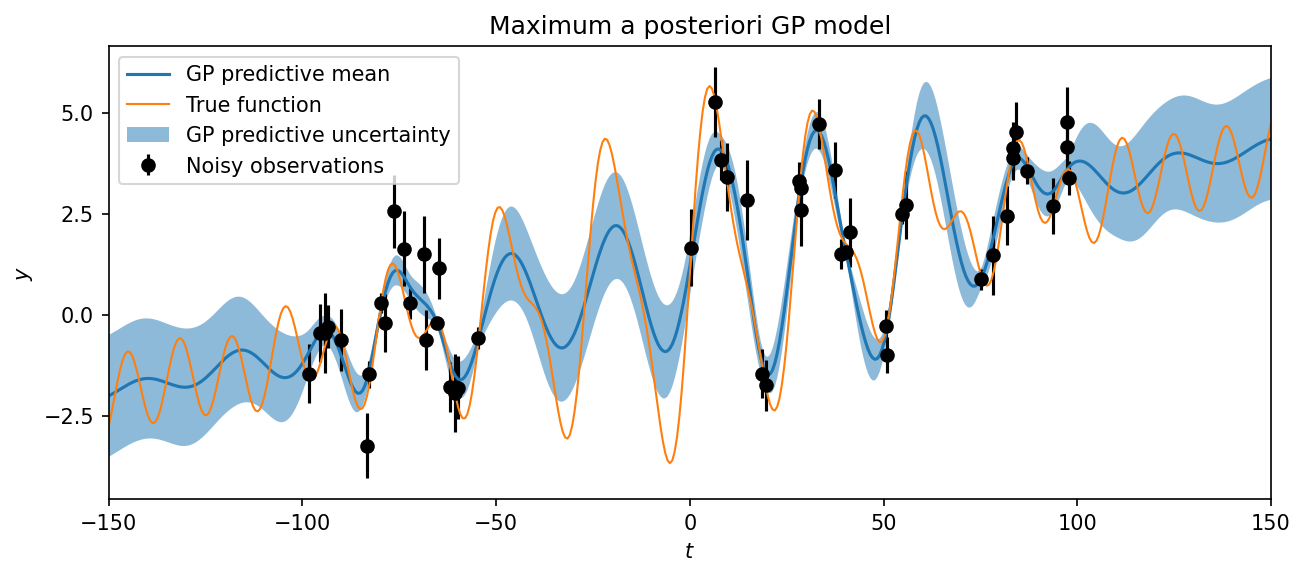

In [39]:
# Plot the data

plt.figure(figsize=(10,4),dpi=150)

plt.errorbar(t_obs, y_obs, yerr=yerr, fmt="ko", capsize=0,
            label='Noisy observations')
plt.plot(t_true, pred_mean, label='GP predictive mean')
plt.plot(t_true,y_true,lw=1, label='True function')
plt.fill_between(t_true, pred_mean+pred_std, pred_mean-pred_std, alpha=0.5,
                 label='GP predictive uncertainty',
                 edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-150, 150)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title('Maximum a posteriori GP model')

plt.legend()

## Let's see what happens if we give celerite 10x the no. of observations

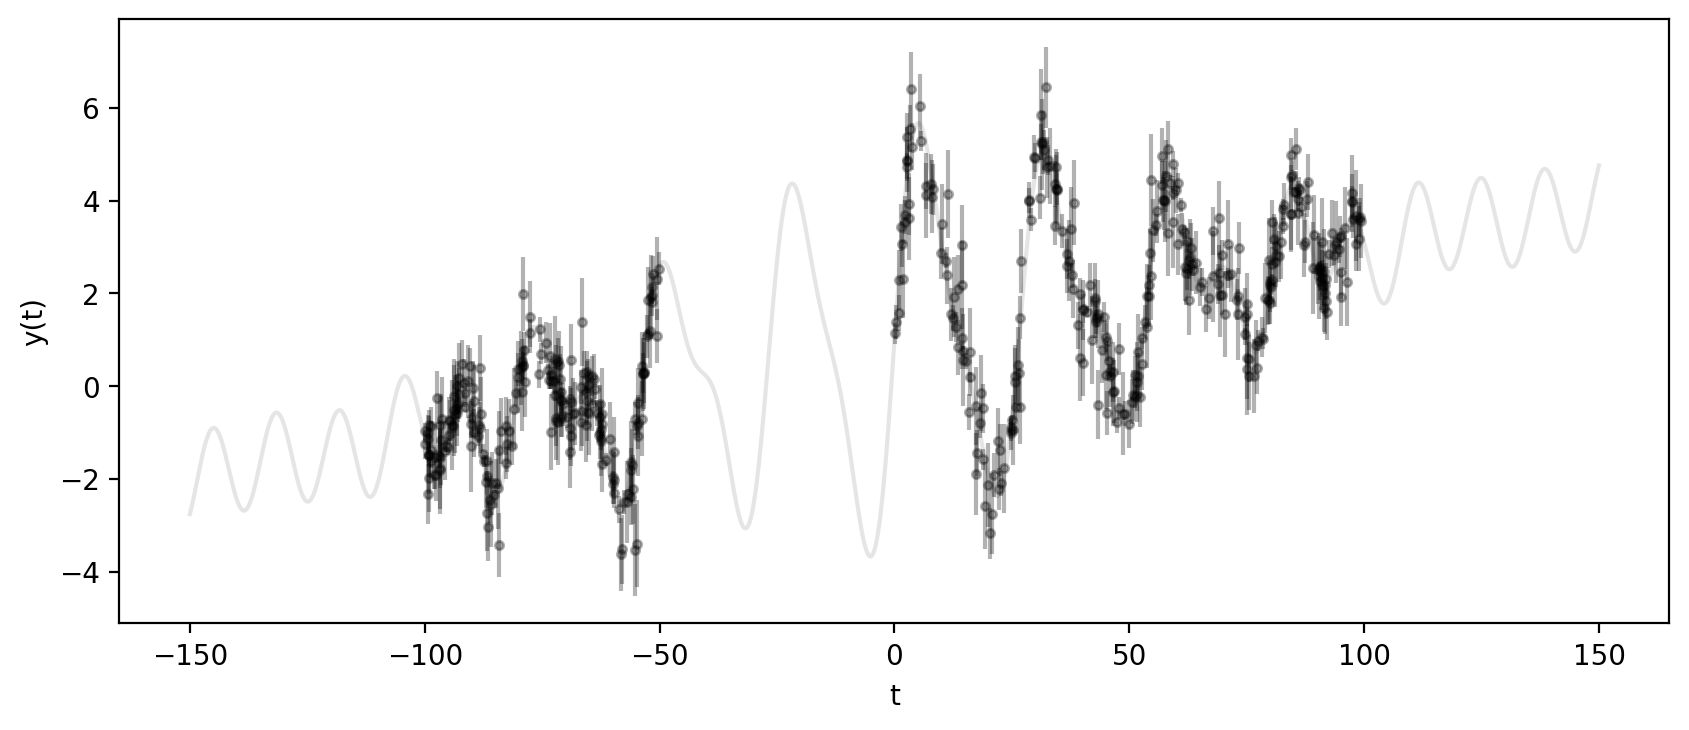

In [40]:
np.random.seed(1)

t_obs = np.sort(np.append(
    np.random.uniform(-100, -50, 200),
    np.random.uniform(0, 100, 300),)) 

yerr = np.random.uniform(0.1, 1.0, len(t_obs))

y_obs = quasi_periodic_fxn(t_obs) + yerr*np.random.randn(len(t_obs))

t_true = np.linspace(-150, 150, 2000)
y_true = quasi_periodic_fxn(t_true)

plt.figure(figsize=(10,4),dpi=200)
plt.plot(t_true, y_true, "k", lw=1.5, alpha=0.1)
plt.errorbar(t_obs, y_obs, yerr=yerr, fmt=".k",
             capsize=0,alpha=0.3)
plt.xlabel("t")
plt.ylabel("y(t)");

In [41]:
gp = celerite.GP(kernel,mean=mean_model, fit_mean=True)
gp.compute(t_obs, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y_obs)))

Initial log likelihood: -430.3671980919615


In [42]:
print('celerite')
%timeit gp.log_likelihood(y_obs)
print('our code')
%timeit loglike(theta)

celerite
14.2 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
our code
5.73 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
# Max likelihood fitting
# NB in genreal I don't recommend this approach!
# Rather use the nested sampling (Bayesian) approach, below

# Set up the GP model 

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y_obs, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction

mu, var = gp.predict(y_obs, t_true, return_var=True)
std = np.sqrt(var)

Final log-likelihood: -415.8347670312119


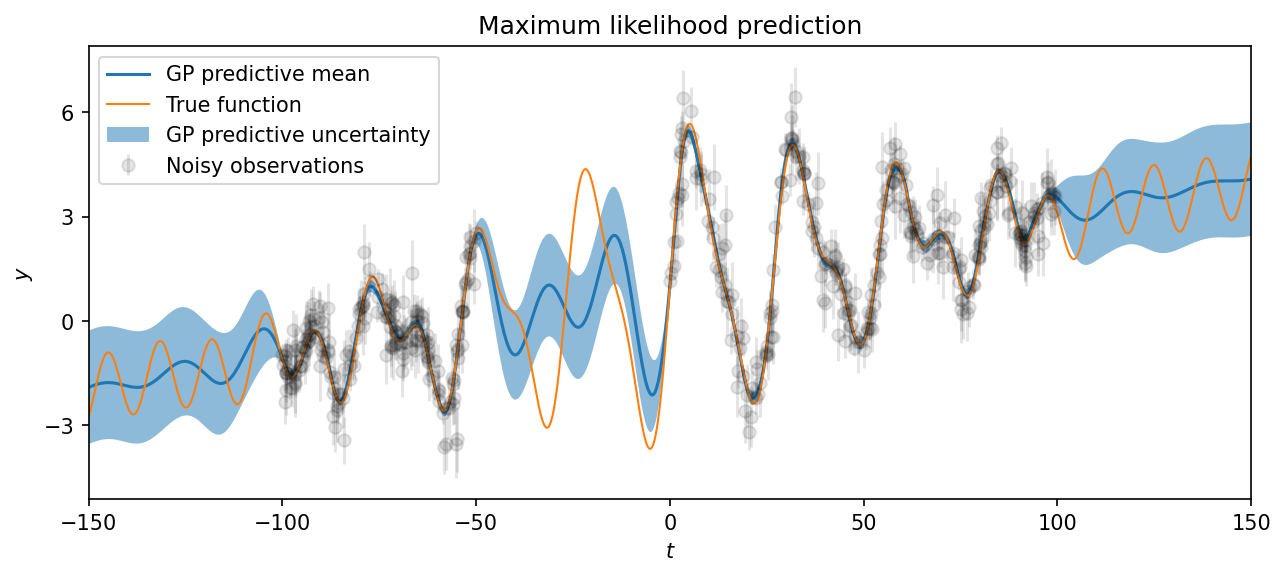

In [44]:
# Plot the data

plt.figure(figsize=(10,4),dpi=150)
plt.errorbar(t_obs, y_obs, yerr=yerr, fmt="ko", capsize=0,
            label='Noisy observations',alpha=0.1)
plt.plot(t_true, mu, label='GP predictive mean')
plt.plot(t_true,y_true,lw=1, label='True function')
plt.fill_between(t_true, mu+std, mu-std, alpha=0.5,
                 label='GP predictive uncertainty',
                 edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-150, 150)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("Maximum likelihood prediction");
plt.legend()

In [45]:
# Initialize our nested sampler
sampler = NestedSampler(log_probability, prior_transform, ndim)

In [46]:
# Uncomment below two lines to run the nested sampler
#sampler.run_nested()
#results = sampler.results

# Or Load results
X = load_dict('DIY_GP_003.pickle')
locals().update(X)

In [47]:
# # Save data to disk
# X = {'sampler': sampler, 'results': results}
# save_dict(X,'DIY_GP_003.pickle')
# # Load results
# X = load_dict('DIY_GP_003.pickle')
# locals().update(X)

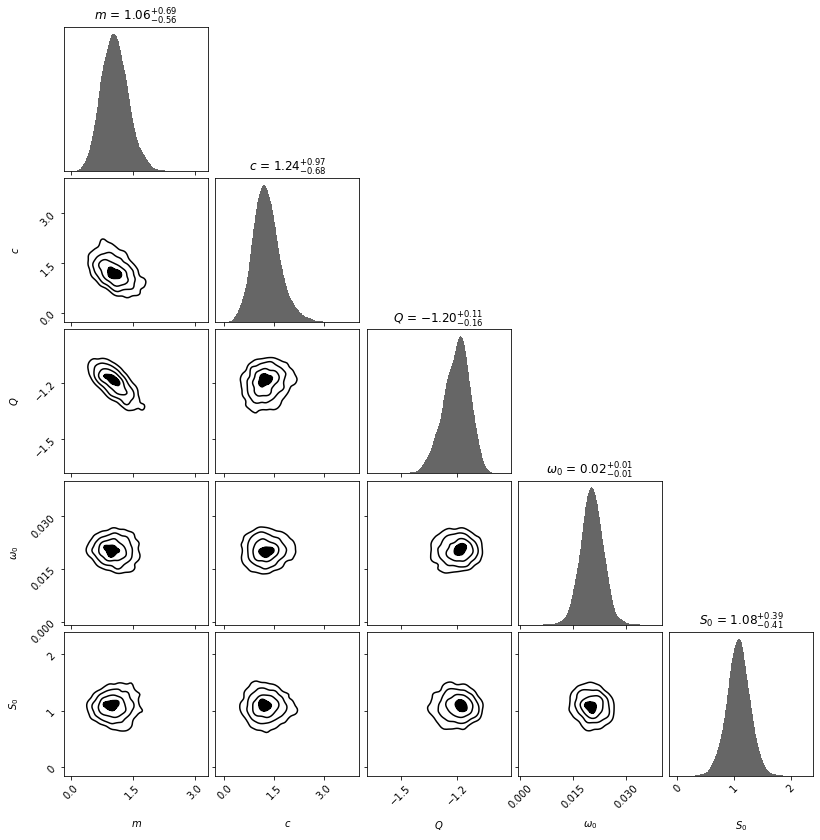

In [48]:
fg, ax = dyplot.cornerplot(results, show_titles=True,
                           quantiles=None, max_n_ticks=3,
                          labels=['$m$','$c$','$Q$','$\omega_0$',
                                  '$S_0$'])

In [49]:
# Extract posterior mean param values
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
gp.set_parameter_vector(mean)

In [50]:
# Get GP predictive mean & variance
pred_mean, pred_var = gp.predict(y_obs, t_true, return_var=True)
pred_std = np.sqrt(pred_var)

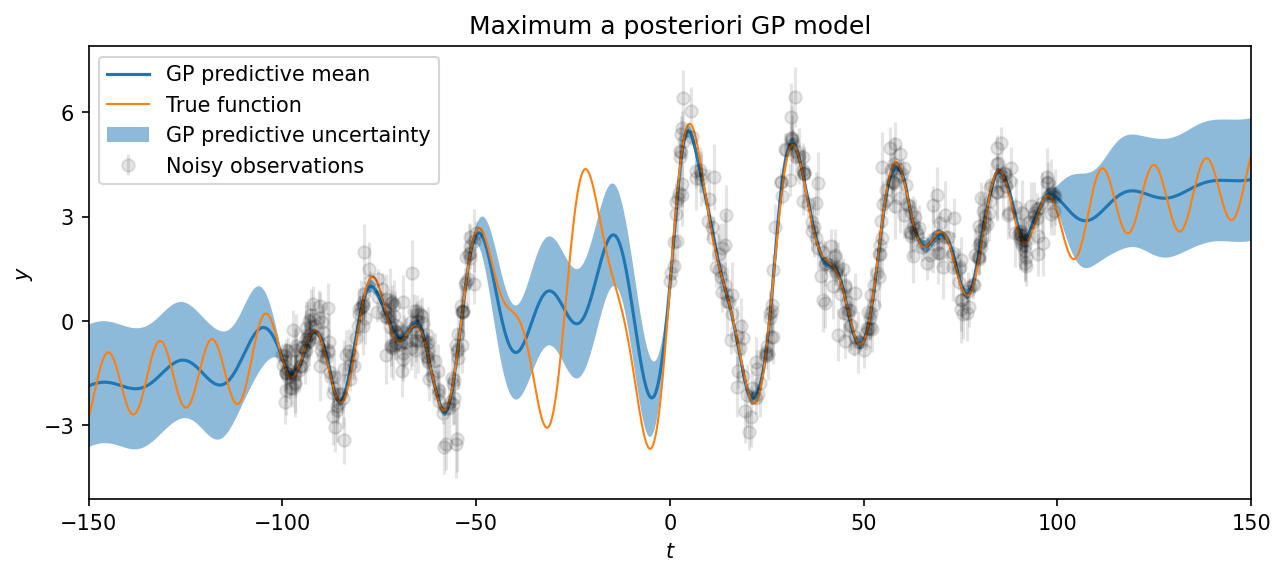

In [51]:
# Plot the data

plt.figure(figsize=(10,4),dpi=150)

plt.errorbar(t_obs, y_obs, yerr=yerr, fmt="ko", capsize=0,
            label='Noisy observations', alpha=0.1)
plt.plot(t_true, pred_mean, label='GP predictive mean')
plt.plot(t_true,y_true,lw=1, label='True function')
plt.fill_between(t_true, pred_mean+pred_std, pred_mean-pred_std, alpha=0.5,
                 label='GP predictive uncertainty',
                 edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-150, 150)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title('Maximum a posteriori GP model')

plt.legend()